<a href="https://colab.research.google.com/github/YosefLab/PopV/blob/main/tabula_sapiens_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Tabula Sapiens as a reference for annotating new datasets

This notebook allows you to annotate your data with a number of annotation methods using the Tabula Sapiens dataset as the reference.

Initial setup:
1. Make sure GPU is enabled (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU)
2. We also highly recommend getting Colab PRO for access to an extended RAM session.


Integration Methods Provided:
- scVI [(Lopez et al. 2018)](https://www.nature.com/articles/s41592-018-0229-2)
- bbKNN [(Polański et al. 2020)](https://academic.oup.com/bioinformatics/article/36/3/964/5545955)
- Scanorama [(He et al. 2019)](https://www.nature.com/articles/s41587-019-0113-3)
- Harmony [(Korsunsky et al. 2019)](https://www.nature.com/articles/s41592-019-0619-0)

Annotation Methods:
- KNN on integrated spaces
- scANVI [(Xu et al. 2021)](https://www.embopress.org/doi/full/10.15252/msb.20209620)
- onClass [(Wang et al. 2020)](https://www.biorxiv.org/content/10.1101/810234v2)
- Celltypist [(Dominguez Conde et al. 2022)](https://www.science.org/doi/10.1126/science.abl5197)
- SVM
- RandomForest

To use the notebook, simply connect to your Google Drive account, set the necessary arguments, select your methods, and run all the code blocks!

**User action is only required in Steps 1-3.**

Last edited: 08/27/2024



## Step 1: Setup environment

We omit the output of those lines for readability.

In [1]:
clone_github_repo = (
    True  # Set to True if running outside of already exisiting Github repository.
)
if clone_github_repo:
    !git clone https://github.com/czbiohub/PopV.git

Cloning into 'PopV'...
remote: Enumerating objects: 2083, done.
remote: Counting objects: 100% (257/257), done.
remote: Compressing objects: 100% (179/179), done.


In [ ]:
!pip install popv

## Restart the Session after installation (User Action Required)

Runtime -> "Restart session"

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%capture
import os

import pandas as pd
import popv
import scanpy as sc

2025-01-04 23:30:36.217933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736062236.265682  434643 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736062236.278897  434643 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Step 2: Load your data (User Action Required)
Here we provide three options to load your data:
1. Connect to Google Drive (highly recommended)
2. Download your data from the cloud and save into this session or on Google drive.
3. Upload your data manually into this session (files are not persistent and will be deleted when session is closed)

As an example, we use a subsampled version of the [Lung Cell Atlas](https://hlca.ds.czbiohub.org/) \[1] for our query data.

\[1] Travaglini, K. et al. A molecular cell atlas of the human lung from single-cell RNA sequencing. *Nature* **587**, 619–625(2020).

In [29]:
output_folder = "tmp_testing"
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [30]:
input_file = {
    "source": "wget",
    "path": "tmp_testing/LCA.h5ad",
    "link": "https://www.dropbox.com/s/mrf8y7emfupo4he/LCA.h5ad?dl=1",
}

if input_file["source"] == "gdrive":
    # OPTION 1: Connect to Google Drive
    # This is the recomended method especially for large datasets
    from google.colab import drive

    drive.mount("/content/drive")
    query_adata = sc.read(input_file["path"])
elif input_file["source"] == "local":
    # OPTION 2: Uploading data manually
    # Click the folder icon on the left navigation bar, and select the upload icon
    # Note: Manually uploaded data is automatically deleted when the colab session ends
    # This is not recommended if your dataset is very large
    query_adata = sc.read(input_file["path"])
else:
    # OPTION 3: Downloading from the cloud (Dropbox, AWS, Google Drive, etc)
    # Google Colab supports wget, curl, and gdown commands
    # It is recommended to download the data into Google Drive and read from there.
    # This way your data will be persistent.
    print("downloading")
    try:
        !wget -O {input_file['path']} "{input_file['link']}"
        query_adata = sc.read(input_file["path"])
    except:
        raise Exception(
            "Default download failed with wget. Use custom downloader or check provided link "
            + input_file["link"]
        )

query_adata.obs_names_make_unique()
#Downsample to reduce RAM usage. Not necessary with Google Colab Pro.
sc.pp.subsample(query_adata, 0.2)

downloading
--2025-01-05 00:12:26--  https://www.dropbox.com/s/mrf8y7emfupo4he/LCA.h5ad?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.13.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.13.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/5henh04air005wccgxbje/LCA.h5ad?rlkey=yqw49zvvkipjfo5a92tkyan6v&dl=1 [following]
--2025-01-05 00:12:26--  https://www.dropbox.com/scl/fi/5henh04air005wccgxbje/LCA.h5ad?rlkey=yqw49zvvkipjfo5a92tkyan6v&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2a7f2a67e6e251bd1f9a96ab53.dl.dropboxusercontent.com/cd/0/inline/ChkzN0xv2q4BiXfBhheXvbIHlgonKNVYEJZxVV_s4gahMwzoa9rGSWJBcNj50IoaWixwrO4ZK5ti3dhkCMOfVhIQKCGiyBawGftazZt8qsQPXaihtBP3fGn5vmVn8IonRXV2jtRFqkCgGz7lFdPiOF1A/file?dl=1# [following]
--2025-01-05 00:12:26--  https://uc2a7f2a67e6e251bd1f9a96ab53.dl.dropboxusercon

## Step 3 (User Action Required): Setting Up Annotation Parameters

Here is where you set the parameters for the automated annotation.

Arguments:
- **tissue:** Tabula Sapiens tissue to annotate your data with. All models are availabel at: https://huggingface.co/popV.
- **save_location:** location to save results to. By default will save to a folder named `annotation_results`. It is highly recommended you provide a Google Drive folder here.
- **query_batch_key:** key in `query_adata.obs` for batch correction. Set to None for no batch correction.
- **algorithms:** these are the methods to run. By default, will run all methods.
Options: ["knn_on_scvi_pred", "scanvi_pred", "knn_on_bbknn_pred", "svm_pred", "rf_pred", "onclass_pred", "knn_on_scanorama_pred",

In [31]:
huggingface_repo = "popV/tabula_sapiens_lung"
query_batch_key = "donor_method"
algorithms = None

## Step 4: Downloading Reference Data and Pretrained Models
No more user input required! Just run all the following code blocks.

**NOTE: PopV has only been evaluated with the Lung/Thymus/Lymph_Node as a reference dataset. Different tissues have different annotation quality and the Tabula sapiens community is currently actively improving the annotation quality. We strongly expect improvement of cell annotation when the updated annotation is released. Upon release the Zenodo repository will be updated.**

In [32]:
popv.settings.num_threads = 10 # Number of threads to use for parallel processing
popv.settings.cuml = True # Use GPU for UMAP and clustering

In [33]:
pd.options.display.max_rows = 300

In [34]:
query_adata = query_adata[:, query_adata.var.index.notna()].copy()

In [35]:
hmo = popv.hub.HubModel.pull_from_huggingface_hub(huggingface_repo, cache_dir="tabula_sapiens_lung")
adata = hmo.annotate_data(
    query_adata,
    query_batch_key=query_batch_key,
    prediction_mode="inference",
    gene_symbols="feature_name",
)

Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 106634.85it/s]


['preprocessing.json', 'accuracies.json', 'OnClass.meta', 'xgboost_classifier.model', 'OnClass.npz', 'metadata.json', 'scvi', 'README.md', 'minified_ref_adata.h5ad', 'faiss_index.faiss', 'scanvi', 'svm_classifier.joblib', 'OnClass.data-00000-of-00001', 'OnClass.index', 'scvi_knn_classifier.joblib', 'celltypist.pkl', 'checkpoint', 'popv_output', 'svm_classifier_cuml.joblib', '.gitattributes', 'obo_dag.joblib', 'harmony_knn_classifier.joblib']
TTTT tabula_sapiens_lung/models--popV--tabula_sapiens_lung/snapshots/7ea0b940a352da337f21d795e3226b5e2dd609a8 tabula_sapiens_lung/datasets--popV--ontology/snapshots/2da43b6e227e76e67b4f32f028886e6308f56246


 12%|█▎        | 1/8 [00:04<00:31,  4.46s/it]

In [10]:
adata.uns["_save_path_trained_models"]

'tabula_sapiens_lung/models--popV--tabula_sapiens_lung/snapshots/7ea0b940a352da337f21d795e3226b5e2dd609a8/'

In [11]:
# Optional: save the full anndata will all objects
# adata.write(f'{output_folder}/query_and_reference_popv.h5ad')

In [12]:
adata

AnnData object with n_obs × n_vars = 80861 × 4000
    obs: 'donor_id', 'tissue_in_publication', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'assay_ontology_term_id', 'sample_id', 'replicate', '10X_run', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_type_ontology_term_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'ethnicity_original', 'scvi_leiden_res05_tissue', 'sample_number', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'disease_ontology_term_id', 'is_primary_data', 'tissue_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissu

In [13]:
cell_types = pd.unique(adata.obs[[i for i in adata.uns['prediction_keys'] if i!='popv_onclass_prediction'] + ['cell_ontology_type']].values.ravel('K'))
palette = sc.plotting.palettes.default_102
celltype_colors = {i: j for i, j in zip(list(cell_types), palette, strict=False)}

In [14]:
len(cell_types)

55

In [15]:
adata.uns['prediction_keys']

['popv_celltypist_prediction',
 'popv_knn_on_bbknn_prediction',
 'popv_knn_on_harmony_prediction',
 'popv_knn_on_scvi_prediction',
 'popv_onclass_prediction',
 'popv_scanvi_prediction',
 'popv_svm_prediction',
 'popv_xgboost_prediction']

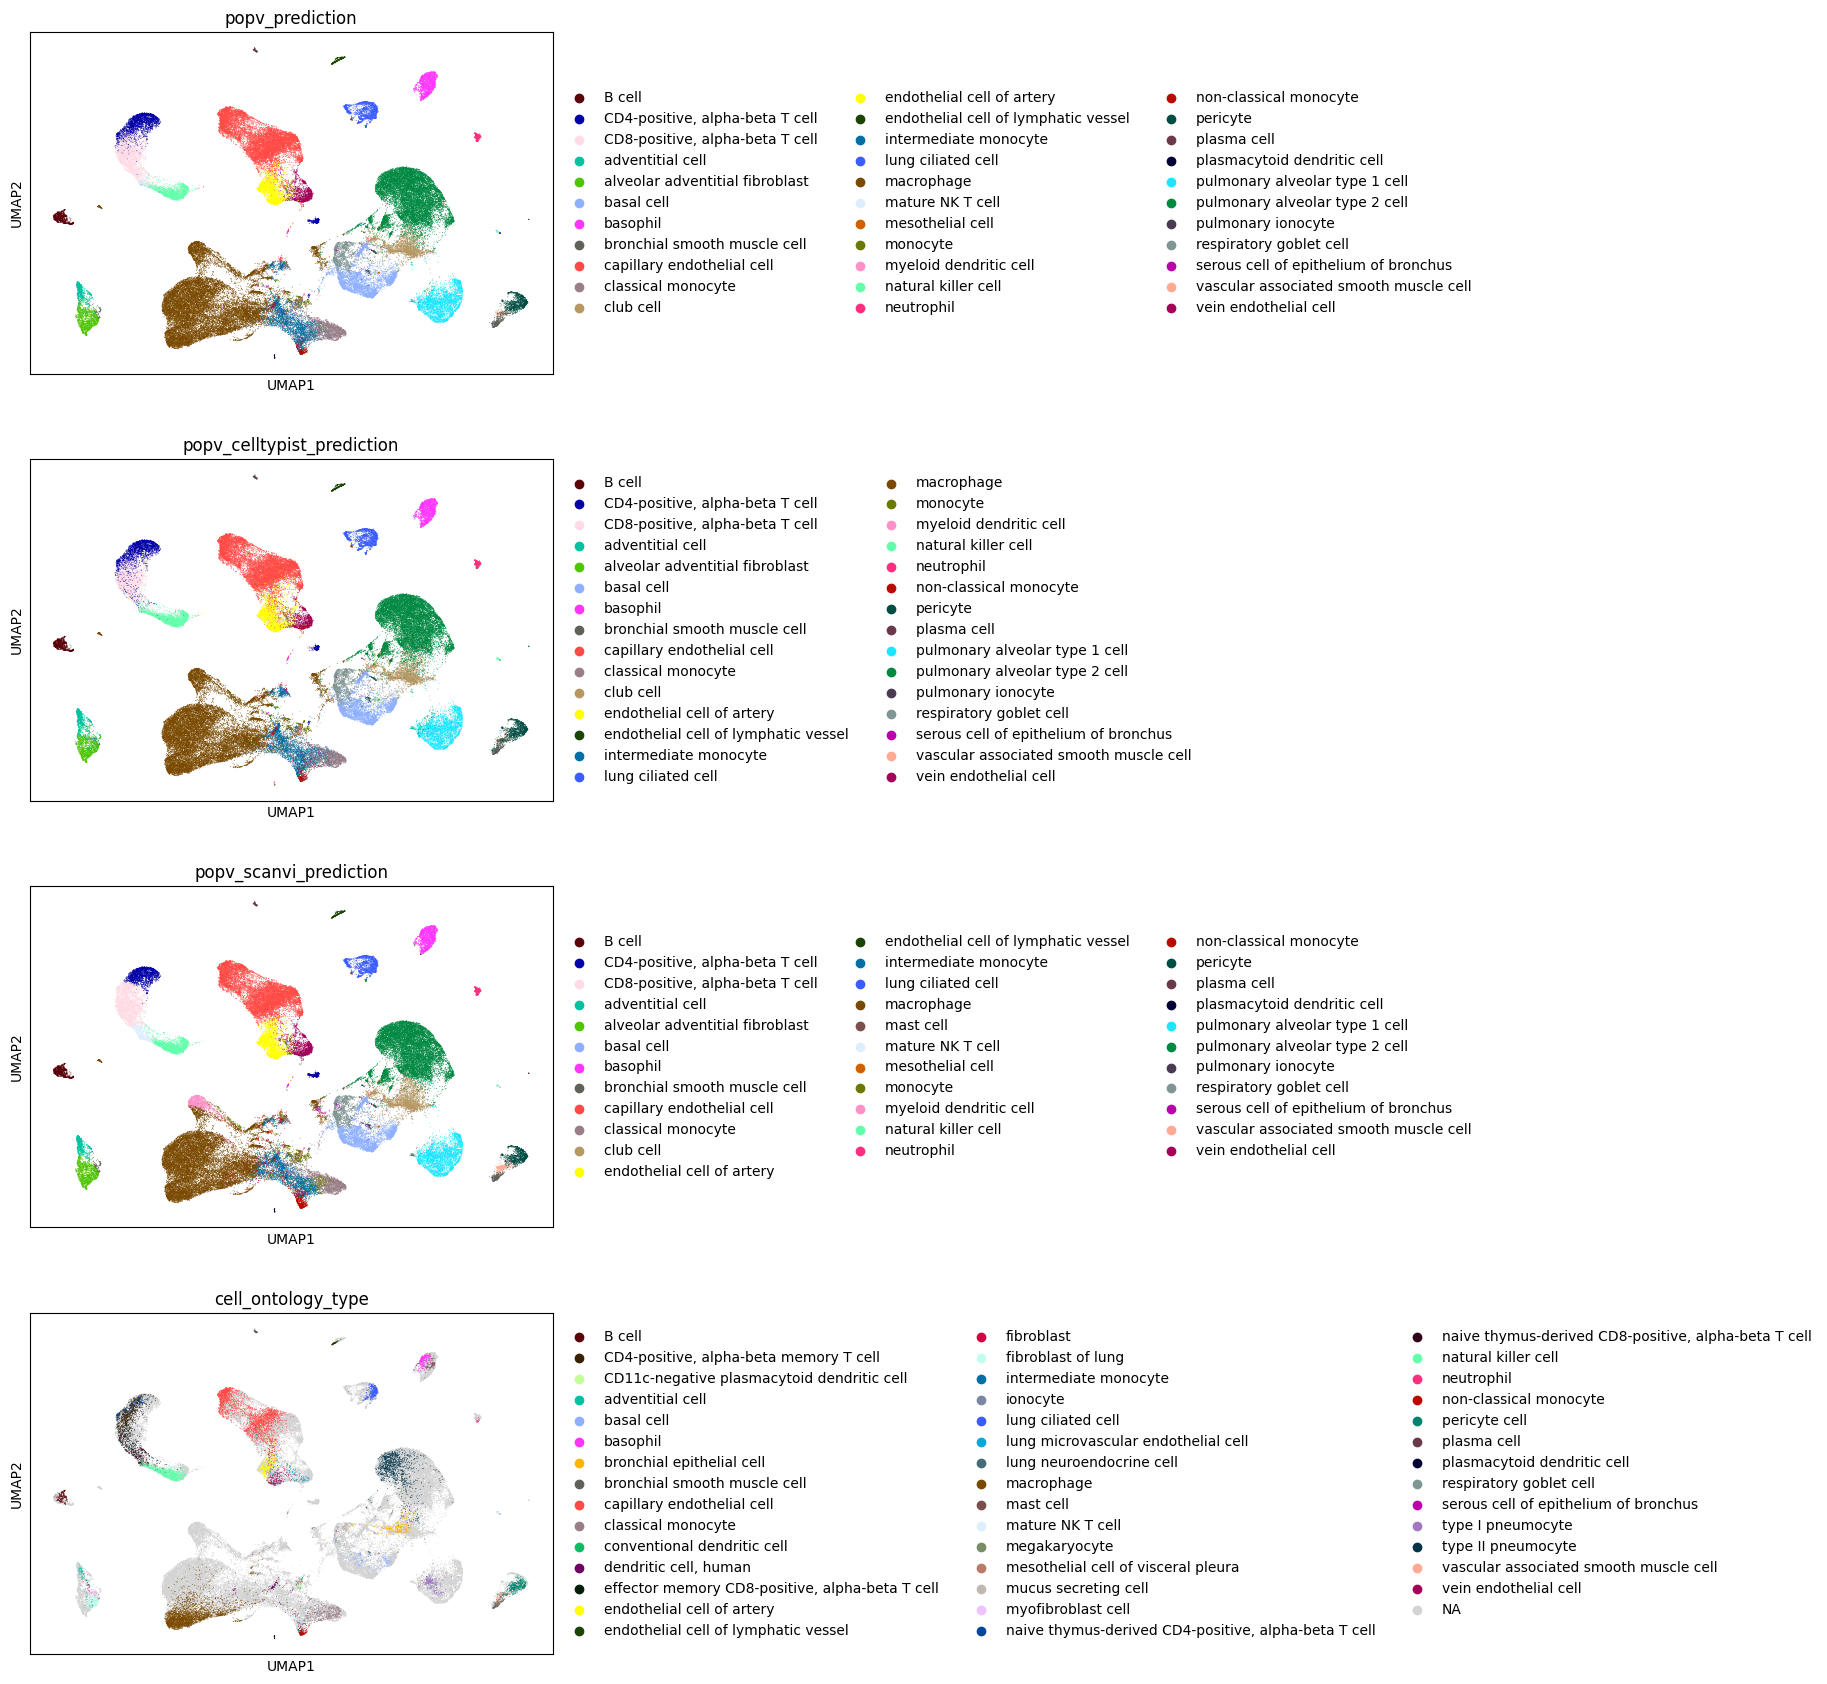

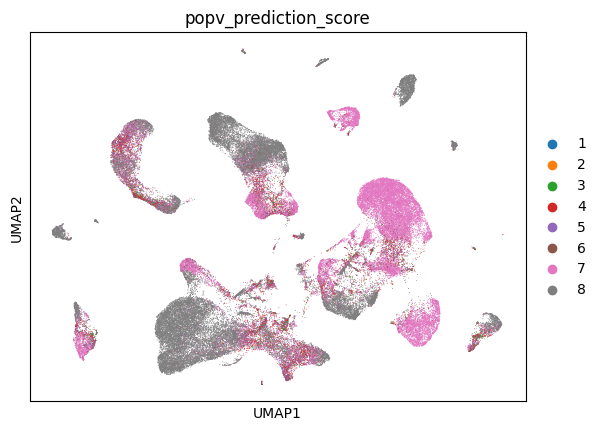

In [17]:
adata.obsm["X_umap"] = adata.obsm["X_scanvi_umap_popv"]

sc.pl.umap(
    adata,
    color=[
        "popv_prediction",
        "popv_celltypist_prediction",
        "popv_scanvi_prediction",
        "cell_ontology_type",
    ],
    palette=celltype_colors,
    ncols=1,
)

sc.pl.umap(
    adata,
    color=[
        "popv_prediction_score",
    ],
    ncols=1,
)

## Step 6: Summary Statistics

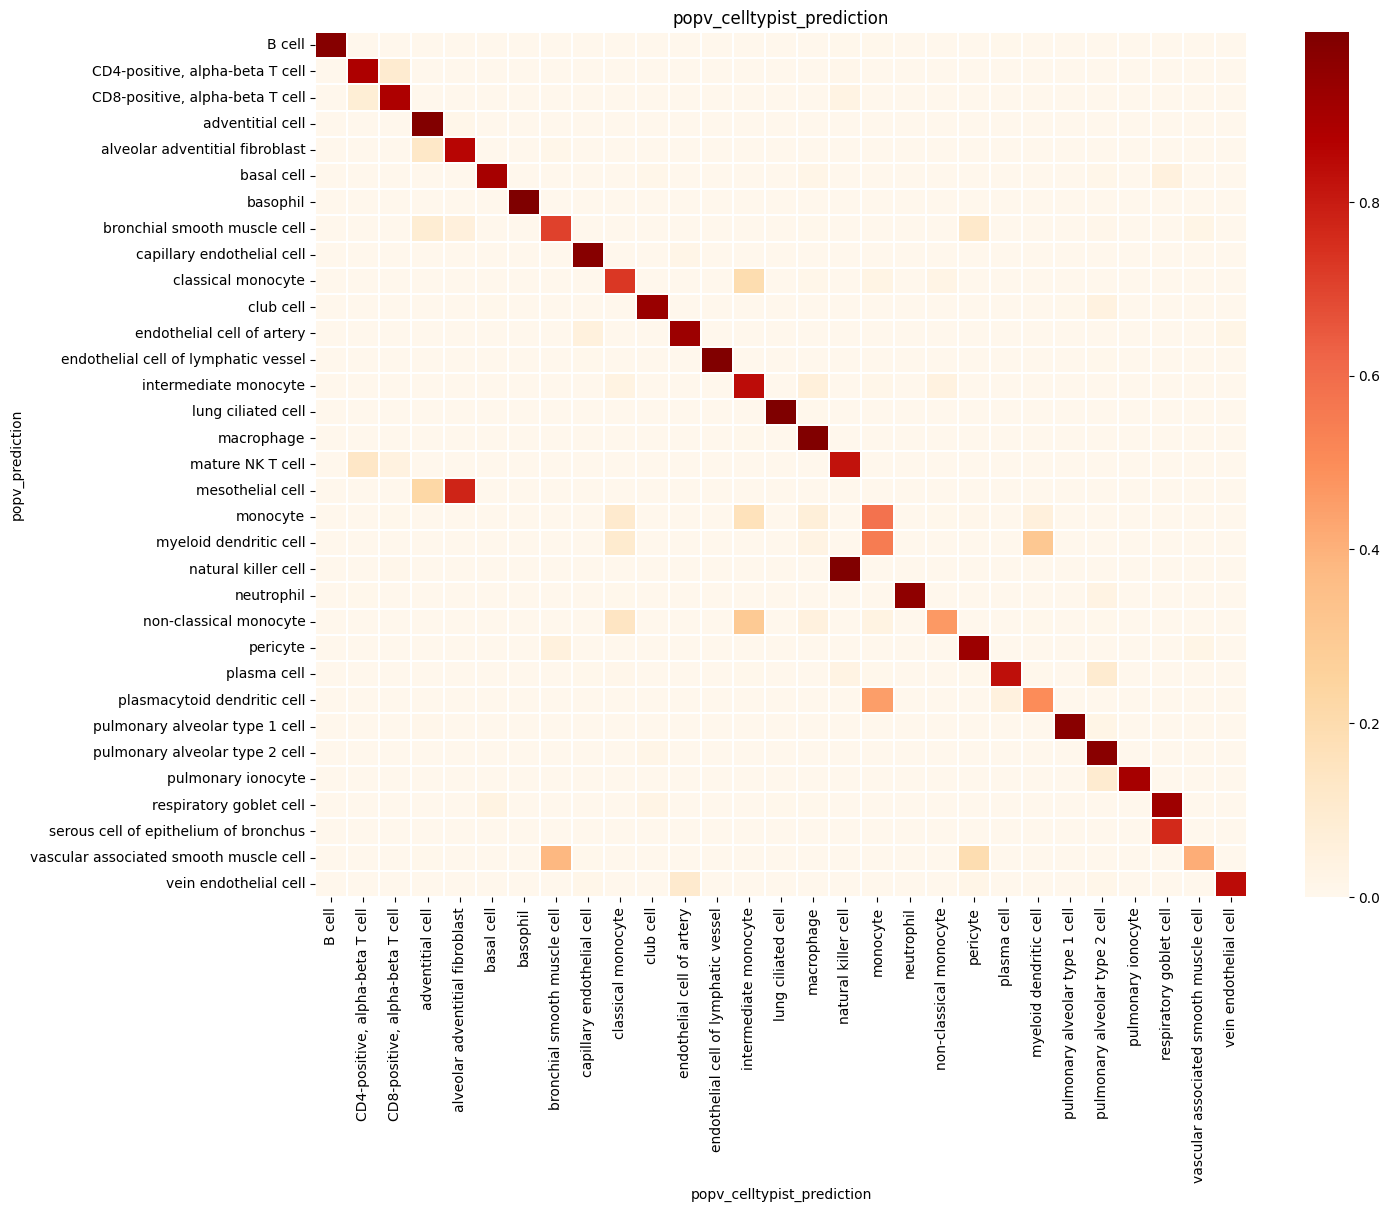

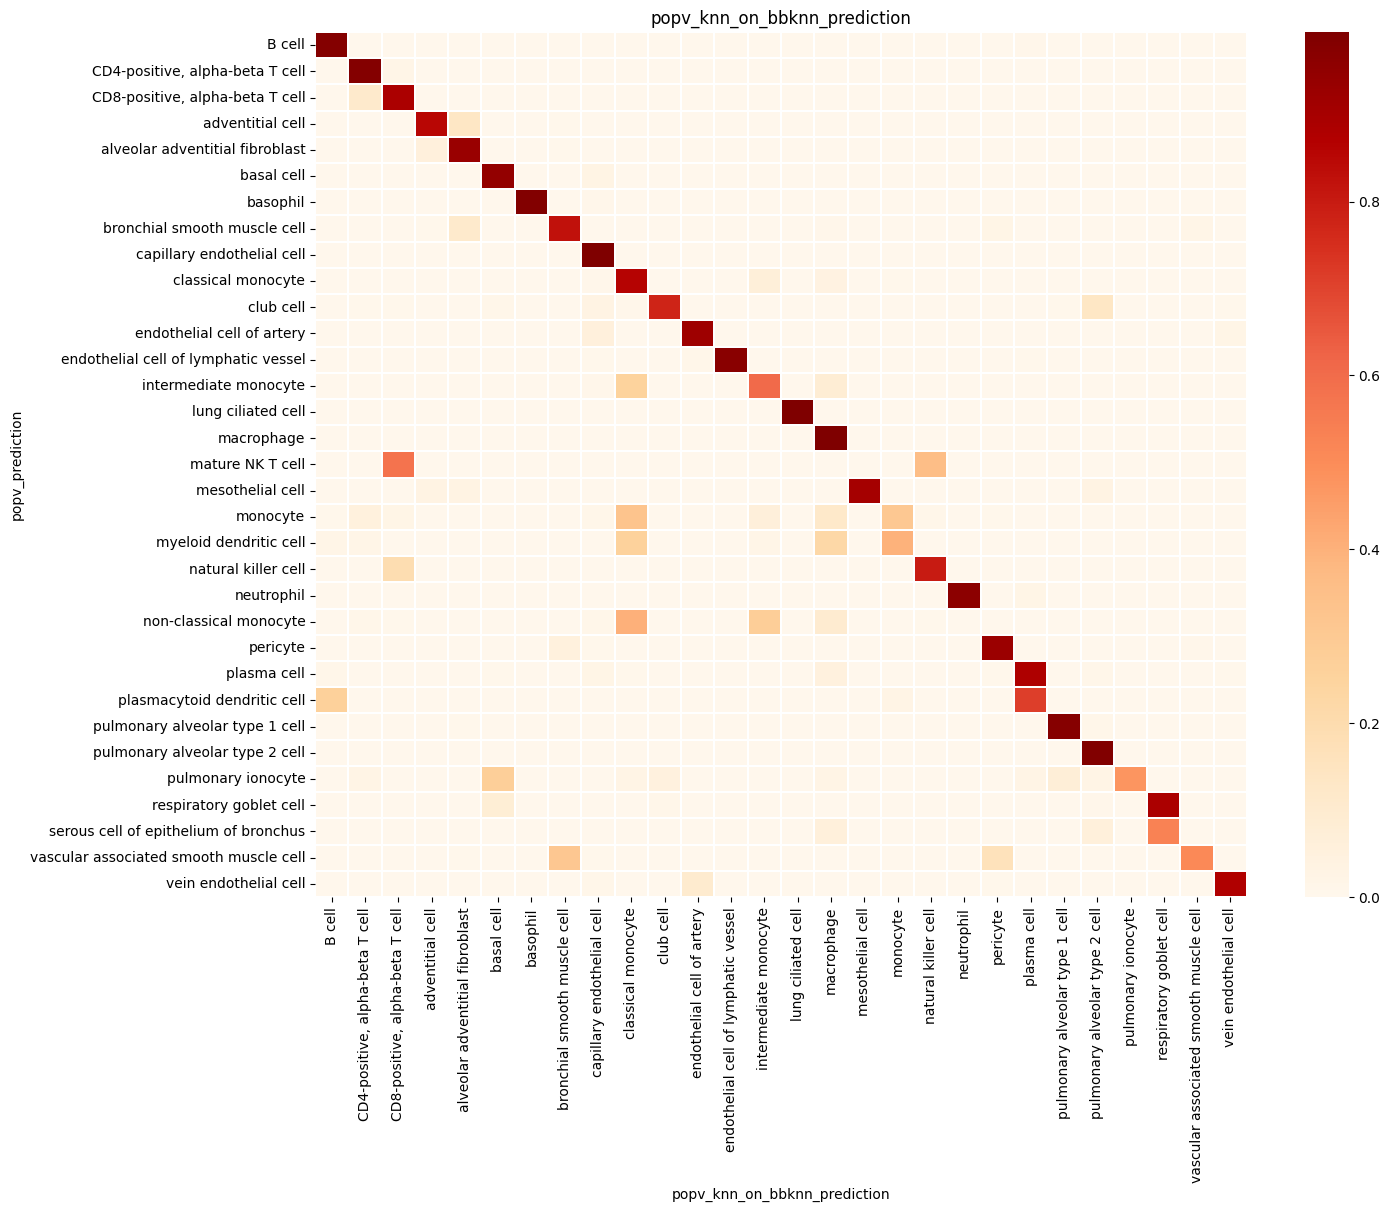

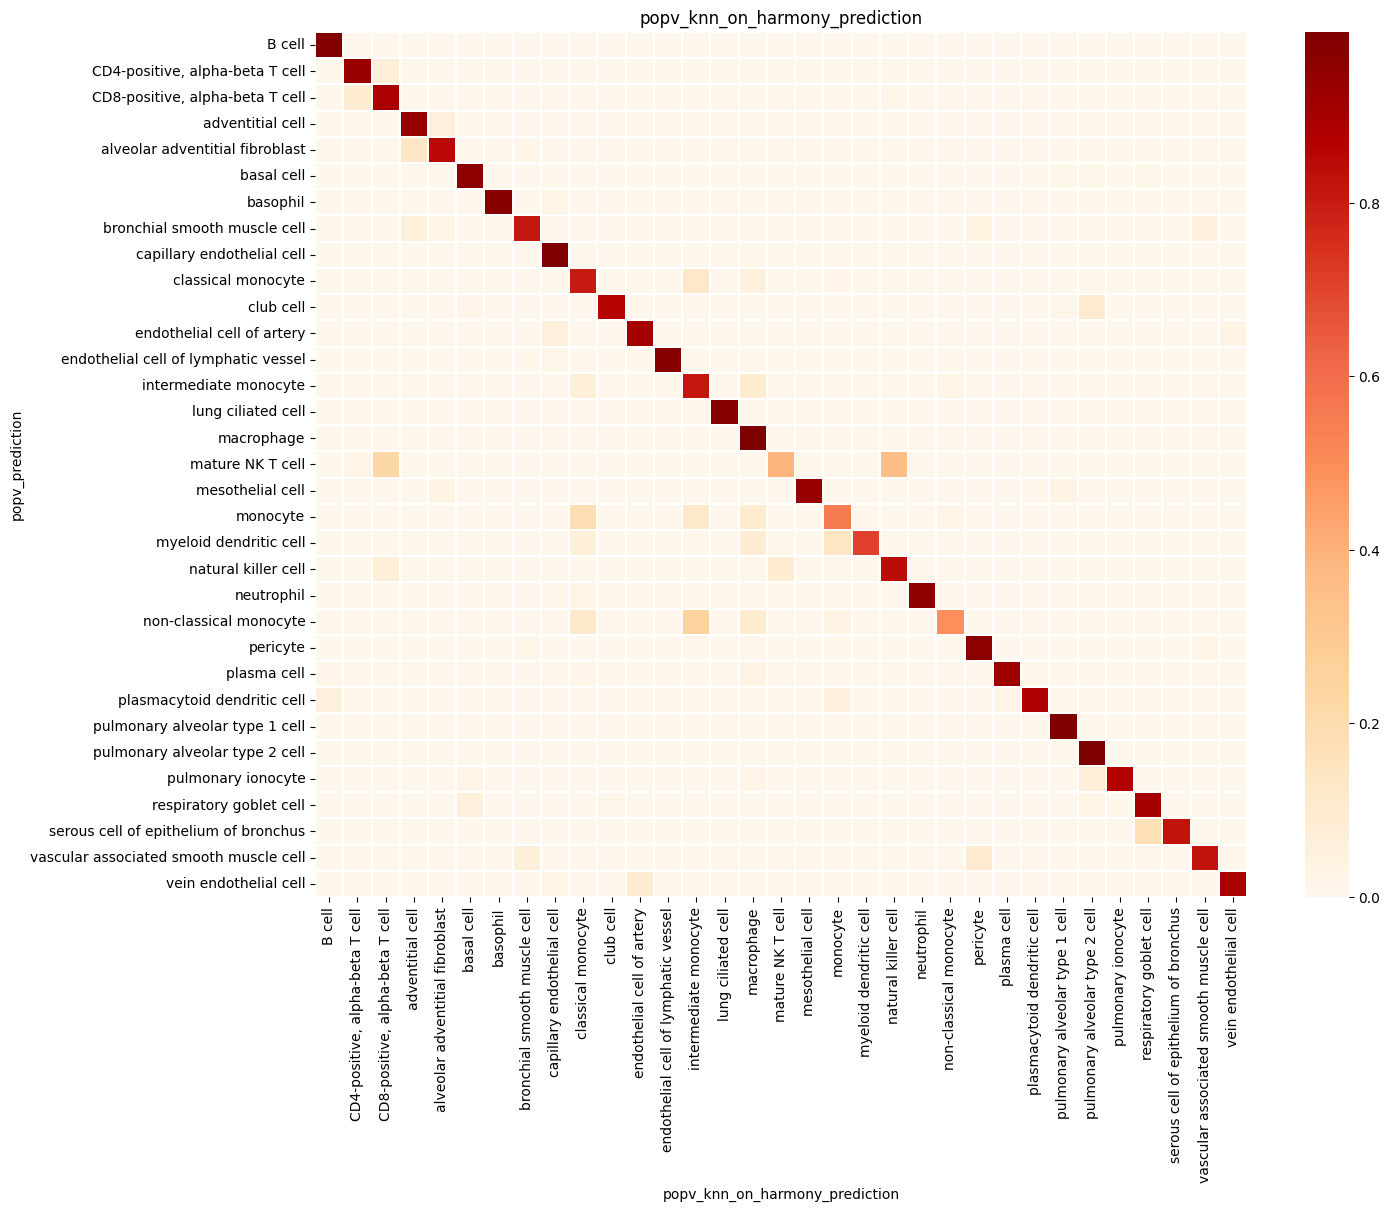

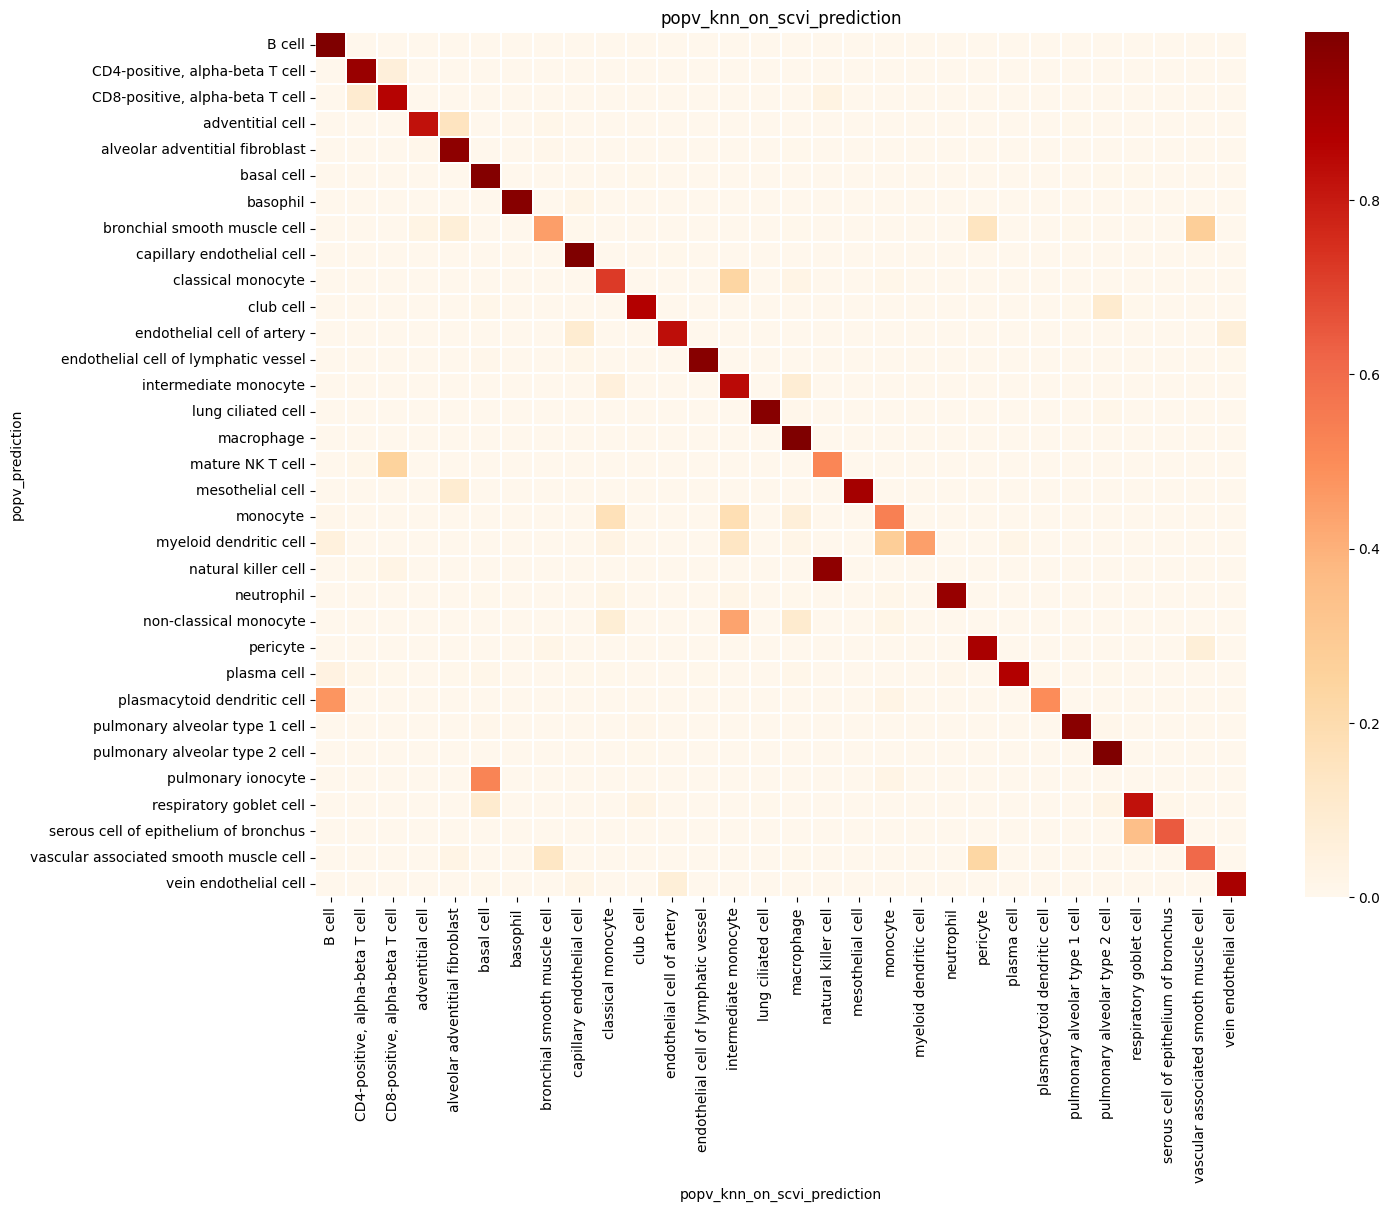

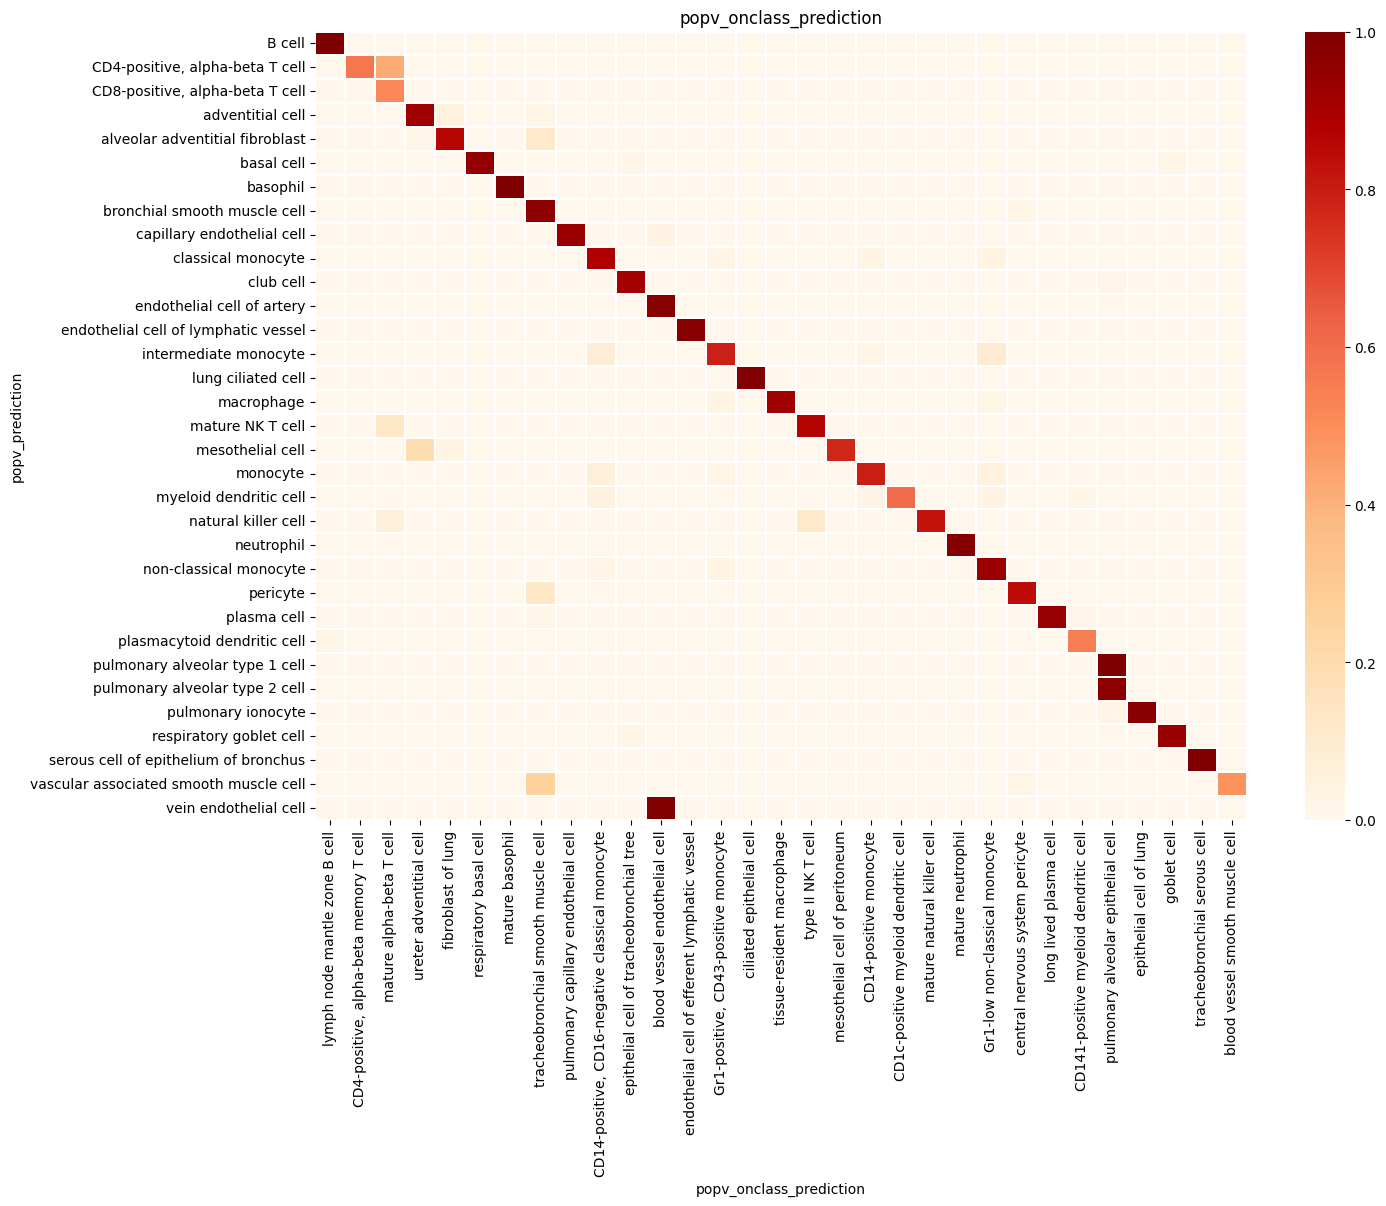

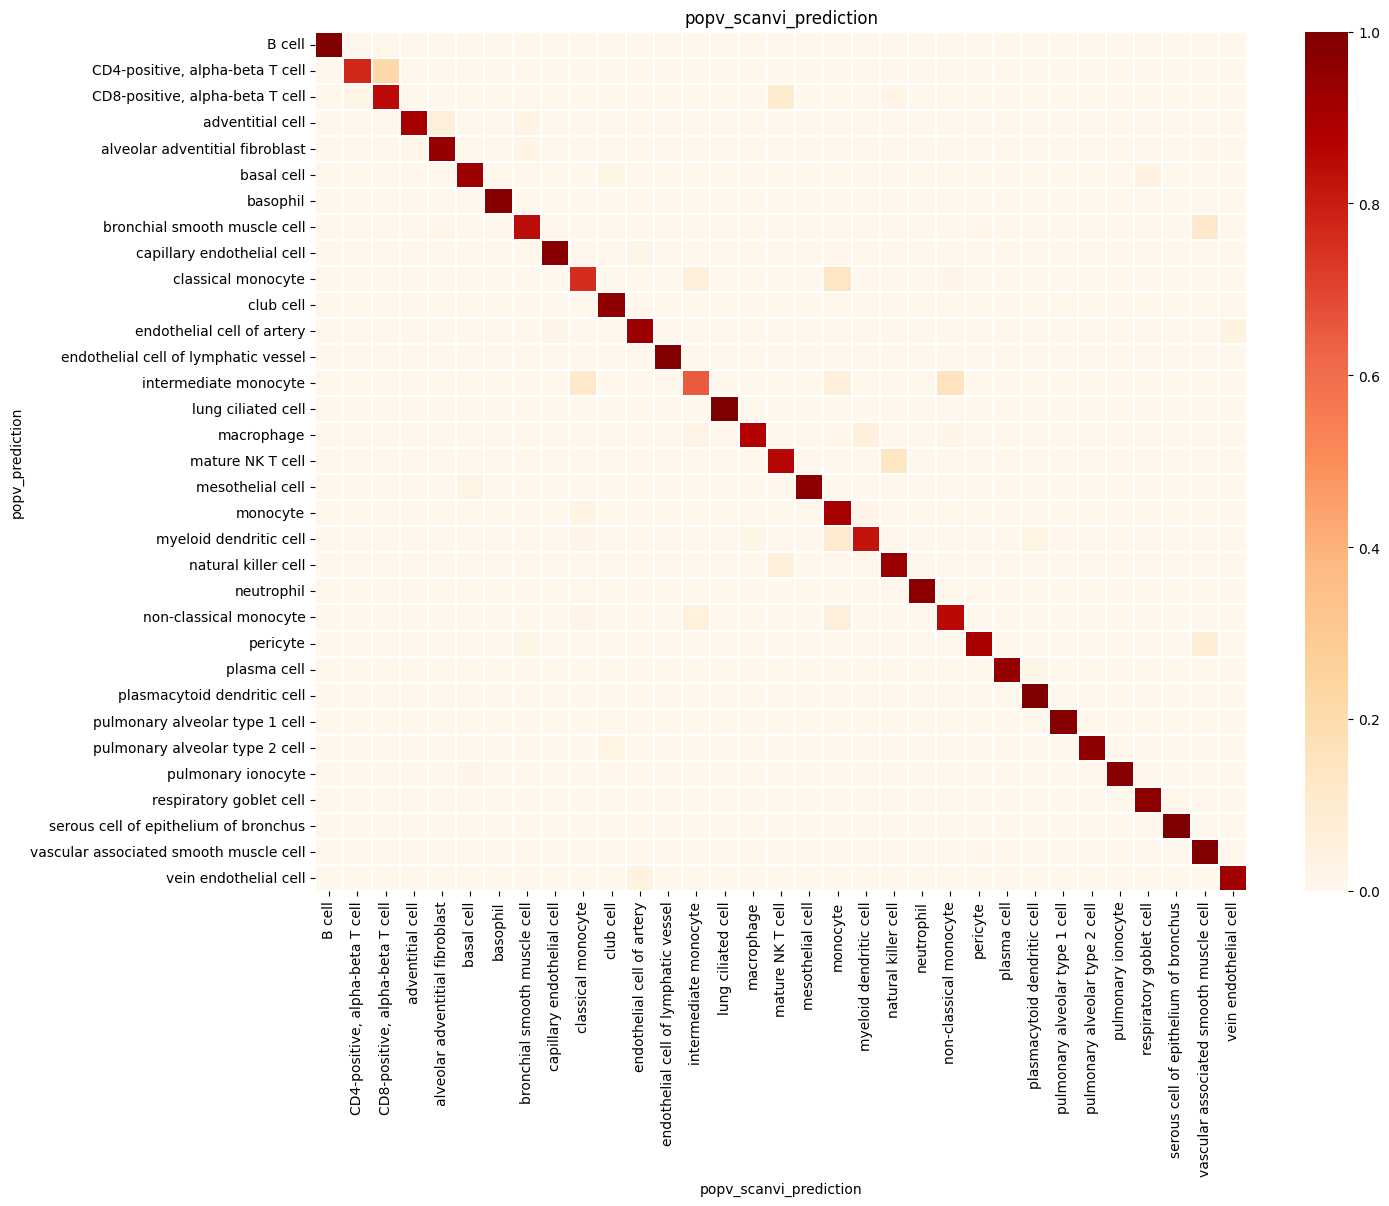

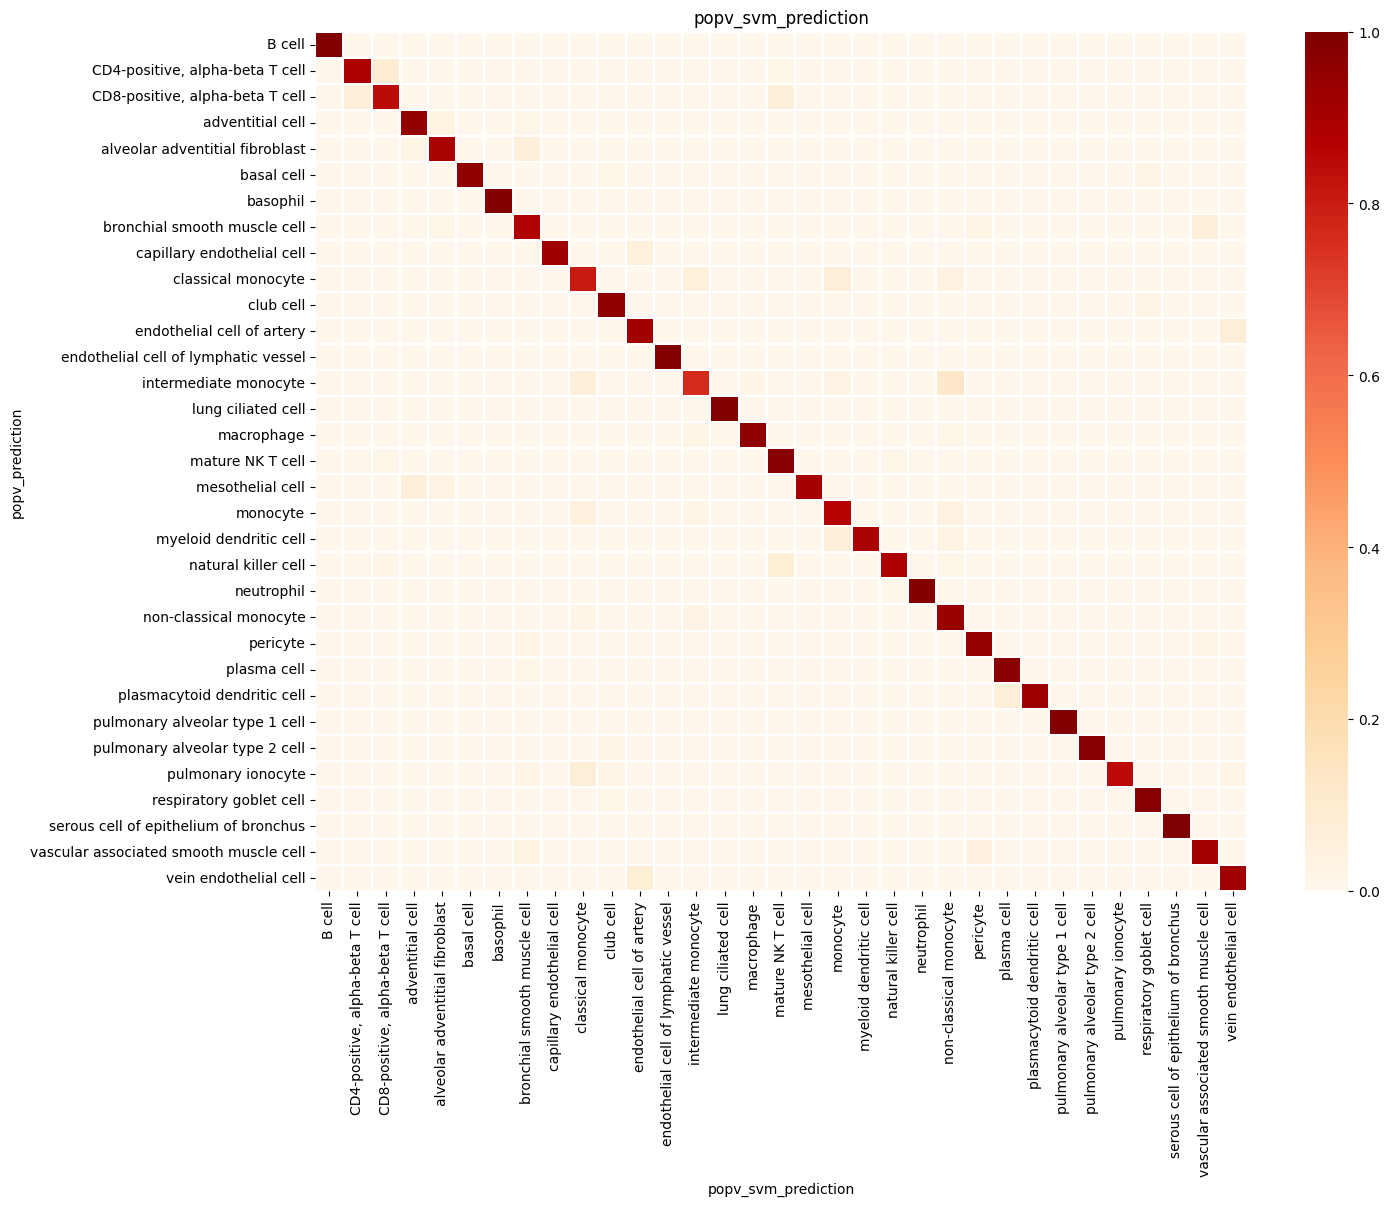

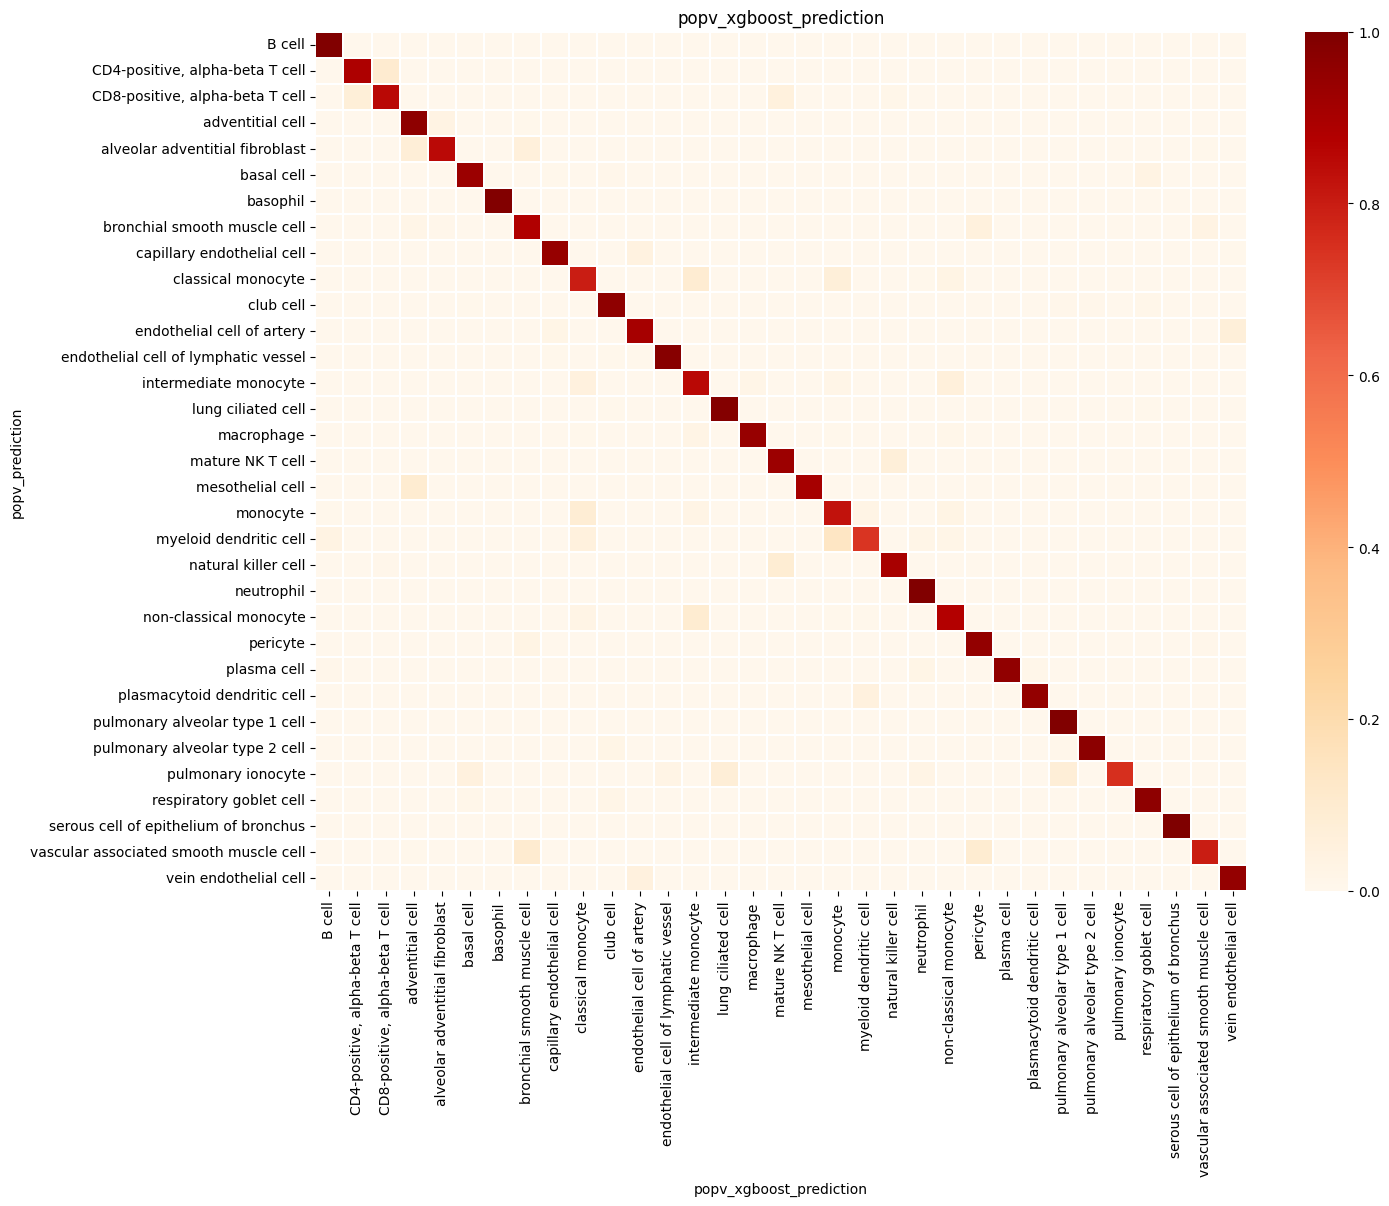

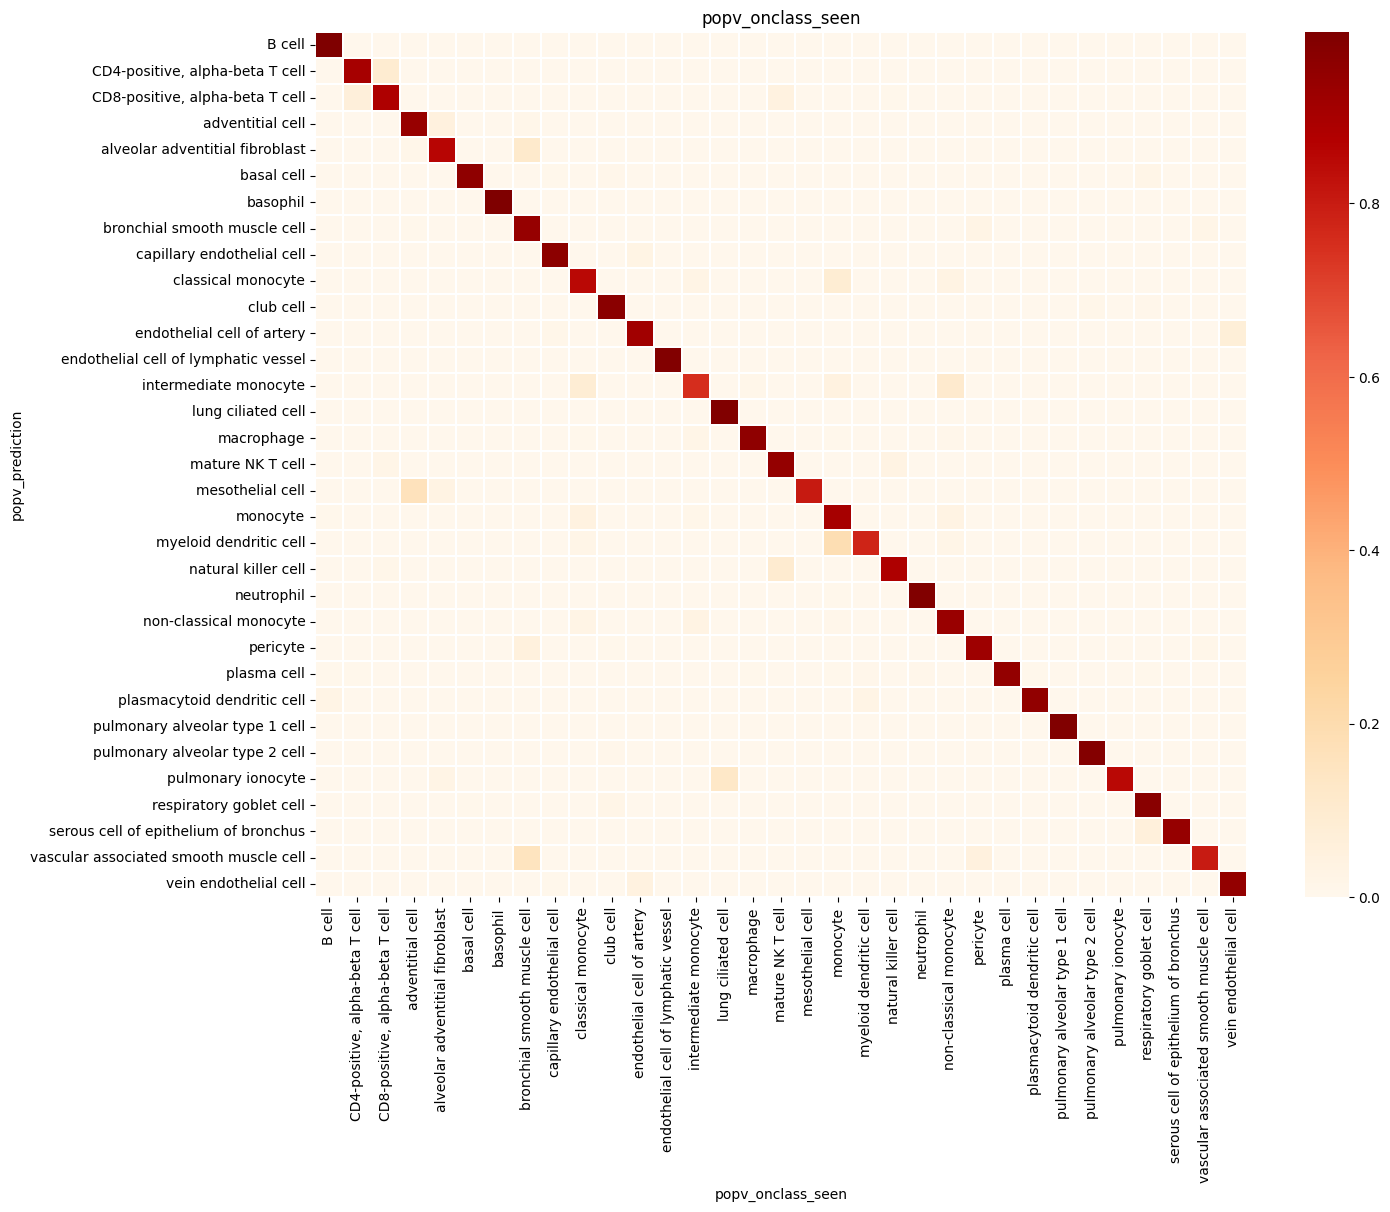

In [18]:
popv.visualization.make_agreement_plots(
    adata,
    prediction_keys=adata.uns["prediction_keys"] + ["popv_onclass_seen"],
    save_folder=output_folder,
)

<Axes: title={'center': 'PopV Prediction Score'}, xlabel='Score', ylabel='Frequency'>

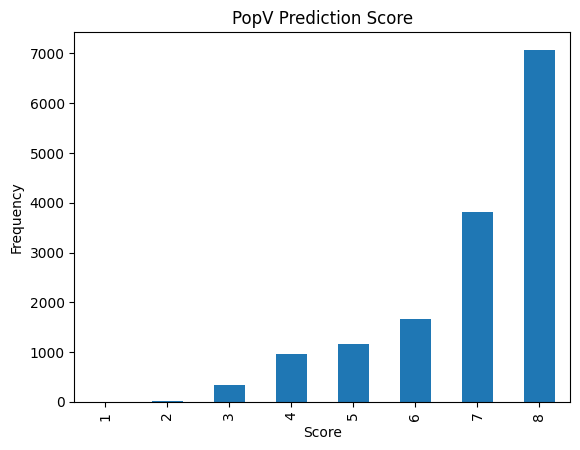

In [19]:
popv.visualization.prediction_score_bar_plot(
    adata, popv_prediction_score="popv_prediction_score"
)

<Axes: ylabel='Mean Agreement'>

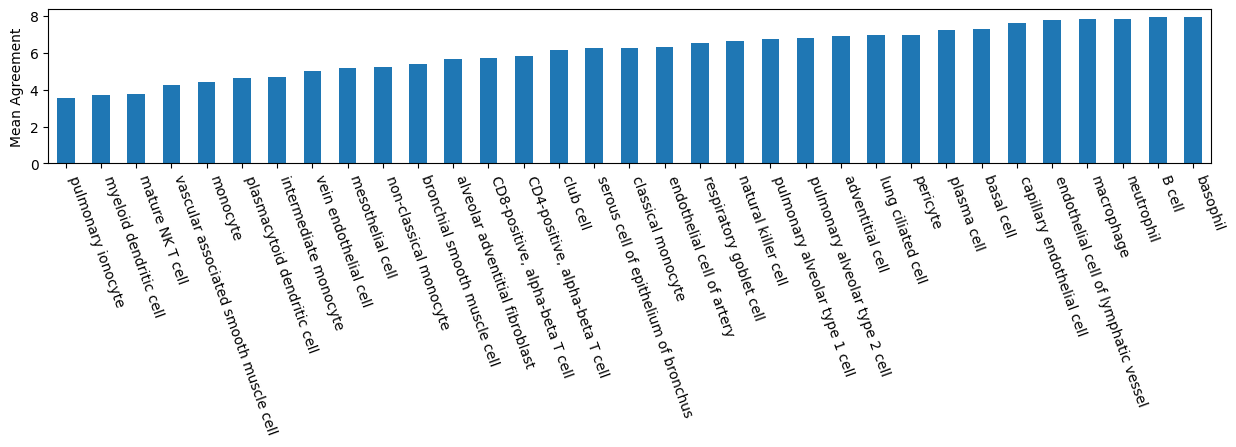

In [20]:
popv.visualization.agreement_score_bar_plot(adata)

### Cell type proportion plot

<Axes: ylabel='Celltype Abundance'>

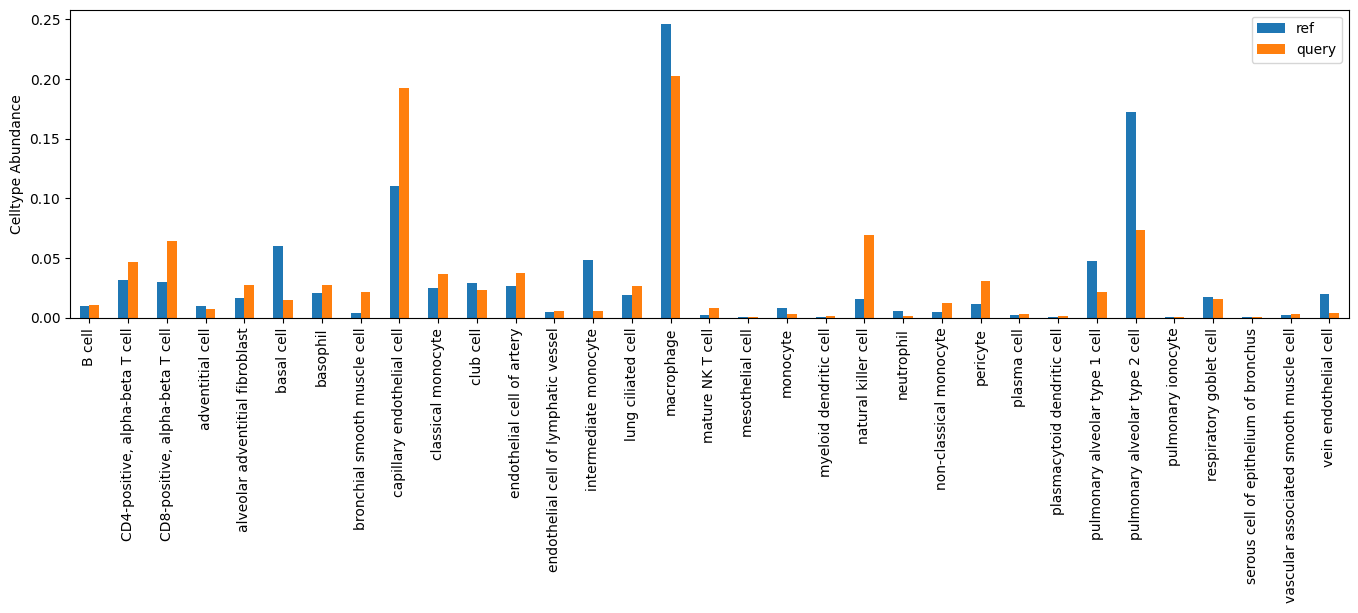

In [21]:
popv.visualization.celltype_ratio_bar_plot(adata)